In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls

datalab  drive


In [5]:
%cd  drive/predict-future-sale

/content/drive/predict-future-sale


   # **Import Modules**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings

#Load Raw Data

In [0]:
sales = pd.read_csv('sales_train_v2.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

###Check whether there are missing values or not

In [8]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


No missing values

In [9]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


#EDA

#Items count per month

## Sum of sales per month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Sum of sales per month')

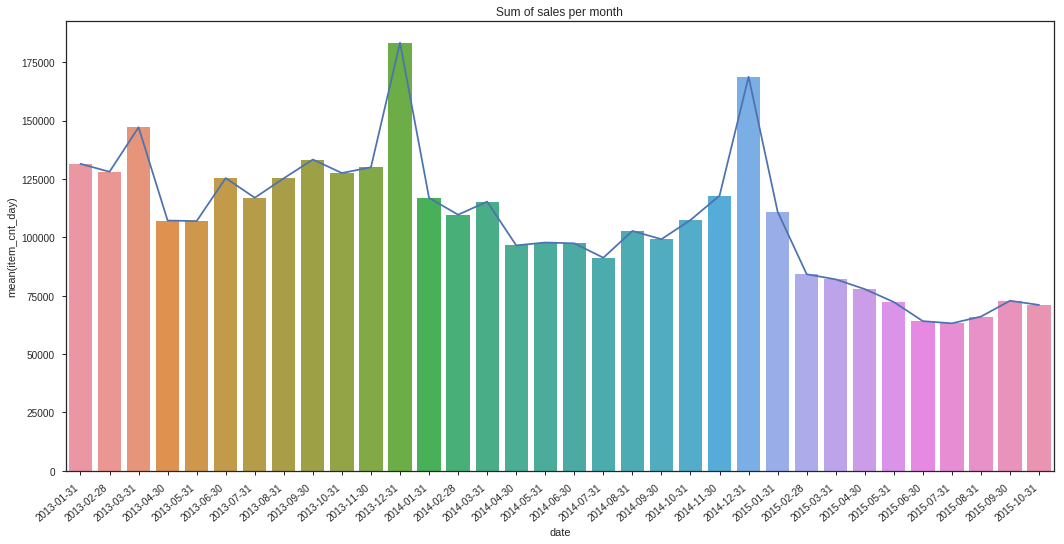

In [10]:
sales_c = sales.copy()

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set(rc={'figure.figsize':(17.7,8.27)})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
sales_c['date'] = pd.to_datetime(sales_c.date,format='%d.%m.%Y')
sales_c['date'] = sales_c['date'].dt.date

sales_c.index = pd.to_datetime(sales_c.date)

items_count_sum = sales_c.groupby(pd.TimeGrouper("M")).sum()['item_cnt_day'].reset_index()
items_count_sum.columns = ['date', 'item_cnt_day']
items_count_sum['date'] = items_count_sum['date'].dt.date

ax = sns.barplot(x ='date', y='item_cnt_day', data=items_count_sum.reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.plot(items_count_sum['item_cnt_day']);
plt.title('Sum of sales per month')


##Mean of sales per month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Mean of sales per month')

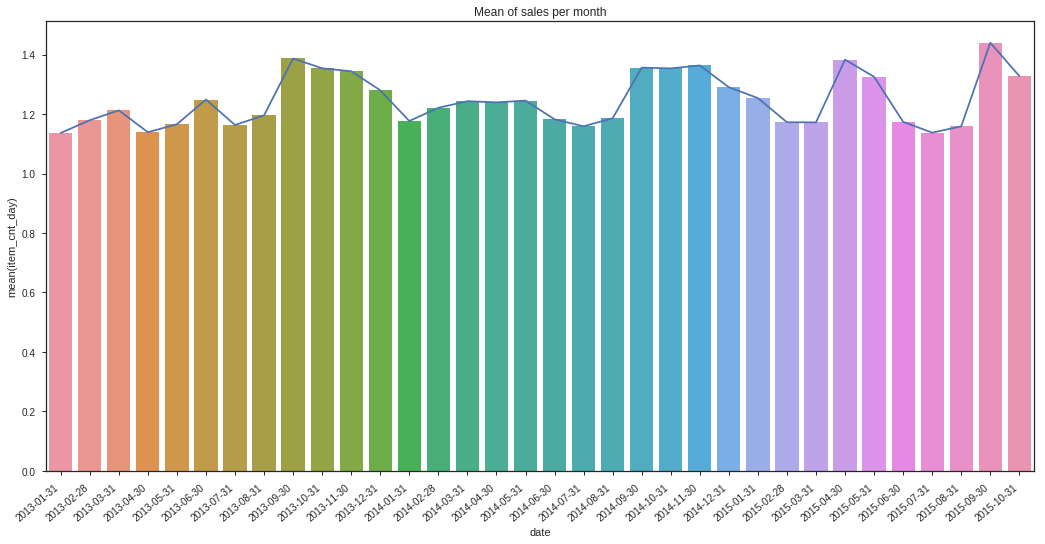

In [11]:
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set(rc={'figure.figsize':(17.7,8.27)})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})

items_count_mean = sales_c.groupby(pd.TimeGrouper("M")).mean()['item_cnt_day'].reset_index()
items_count_mean.columns = ['date', 'item_cnt_day']
items_count_mean['date'] = items_count_mean['date'].dt.date

ax = sns.barplot(x ='date', y='item_cnt_day', data=items_count_mean.reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.plot(items_count_mean['item_cnt_day']);
plt.title('Mean of sales per month')



##Sales per shop

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Sales per shop')

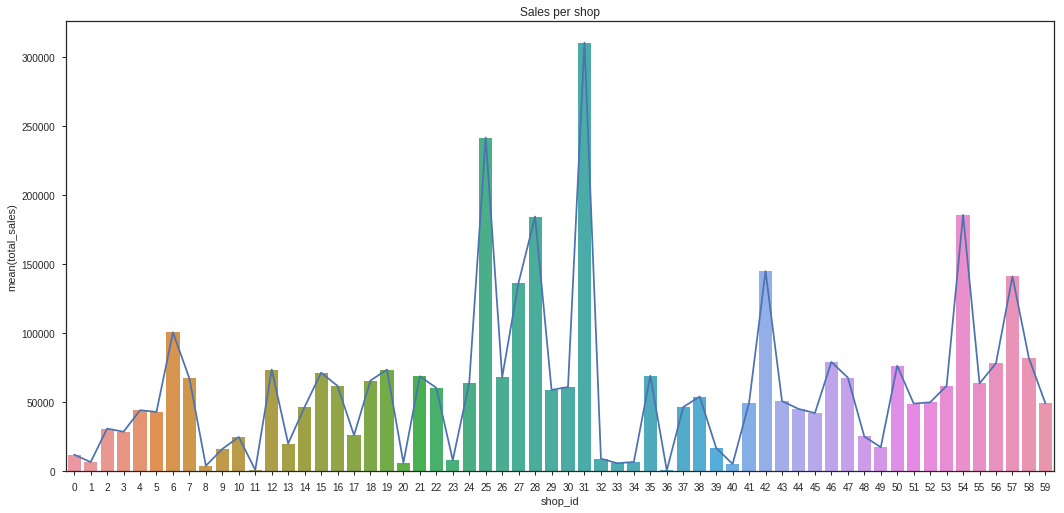

In [7]:
#sales_c = sales.copy()

sns.set_style("whitegrid")
sns.set_context("talk",font_scale = 2)
sns.set(rc={'figure.figsize':(17.7,8.27)})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


items_count = sales_c.groupby(['shop_id']).sum()['item_cnt_day'].reset_index()
items_count.columns = ['shop_id', 'total_sales']

ax = sns.barplot(x ='shop_id', y='total_sales', data=items_count.reset_index())
#ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
plt.plot(items_count['total_sales']);
plt.title('Sales per shop')





In [0]:
sales_c = pd.merge(sales,items,on='item_id')

In [13]:
sales_c = pd.merge(sales_c,item_cats,on='item_category_id')
sales_c

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
5,20.01.2013,0,25,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
6,23.01.2013,0,25,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
7,26.01.2013,0,25,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
8,27.01.2013,0,6,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
9,10.01.2013,0,15,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [0]:
c_sales = sales_c.copy()

##Sales per Item Category Id

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Sales per item category id')

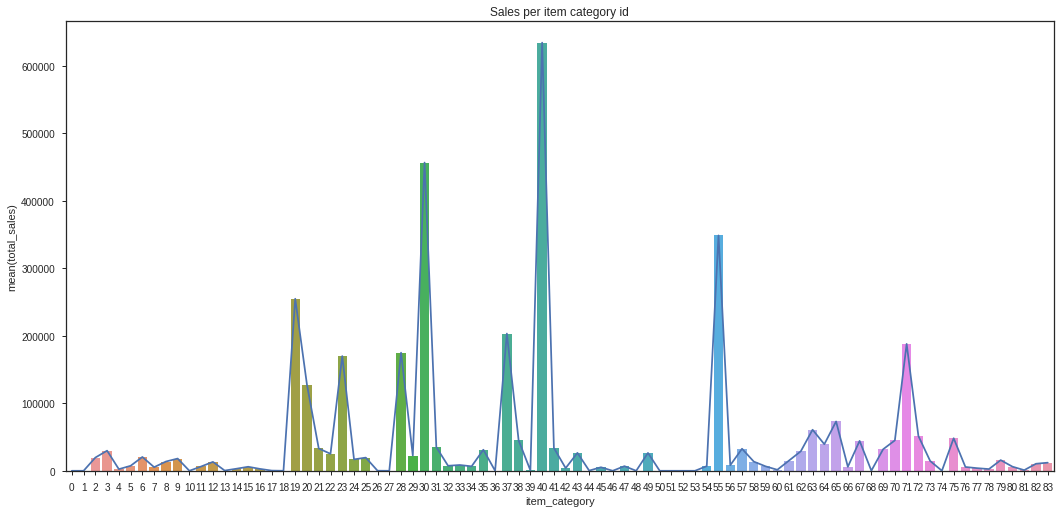

In [16]:
sales_c = c_sales.copy()

sns.set_style("whitegrid")
sns.set_context("talk",font_scale = 2)
sns.set(rc={'figure.figsize':(17.7,8.27)})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


items_count = sales_c.groupby(['item_category_id']).sum()['item_cnt_day'].reset_index()
items_count.columns = ['item_category', 'total_sales']

ax = sns.barplot(x ='item_category', y='total_sales', data=items_count.reset_index())
#ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
plt.plot(items_count['total_sales']);
plt.title('Sales per item category id')

In [0]:
sales_c = c_sales.copy()

In [19]:
sales_c = sales_c.drop(['item_name'],axis = 1)
#sales_c.rename(columns={'item_category_name_y': 'item_category_name'}, inplace=True)
list(sales_c)

['date',
 'date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_cnt_day',
 'item_category_id',
 'item_category_name']

In [0]:
sales_c = sales_c.drop(['item_name'],axis = 1)


In [0]:
sales_c.loc[sales_c.item_category_id == 0, ['item_category_name']] = 'PC - Headsets / Headphones'

for index in range(1,9):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Accessories'  

sales_c.loc[sales_c.item_category_id == 9, ['item_category_name']] = 'Ticket'
sales_c.loc[sales_c.item_category_id == 10, ['item_category_name']] = 'Delivery of goods'

for index in range(11,19):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Game Consoles' 
  
for index in range(19,26):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Games' 
  
sales_c.loc[sales_c.item_category_id == 26, ['item_category_name']] = 'Accessories for games'
sales_c.loc[sales_c.item_category_id == 27, ['item_category_name']] = 'Mobile games'

for index in range(28,33):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'PC games'
  
for index in range(33,38):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Cards'
  
for index in range(38,43):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Movies'
  
for index in range(43,56):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Books'
  
for index in range(56,62):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Music'
  
for index in range(62,74):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Gifts'

for index in range(74,80):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Programs'
  
for index in range(80,82):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Office'
  
for index in range(82,84):
  sales_c.loc[sales_c.item_category_id == index, ['item_category_name']] = 'Carriers'
  
sales_c.loc[sales_c.item_category_id == 84, ['item_category_name']] = 'Food'

In [0]:
sales_c.to_csv('data1.csv', index = False, header = True)


In [22]:
sales_c.sort_values('item_category_id',ascending='False')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
2639924,02.04.2013,3,38,16256,22.4,1.0,0,PC - Headsets / Headphones
2639923,28.02.2013,1,0,16255,93.0,1.0,0,PC - Headsets / Headphones
2639922,10.01.2013,0,25,16257,148.0,1.0,0,PC - Headsets / Headphones
2776001,20.02.2013,1,0,5740,283.0,1.0,1,Accessories
2776000,10.01.2013,0,45,5606,148.0,1.0,1,Accessories
2249340,08.03.2014,14,35,5573,499.0,1.0,2,Accessories
2246412,02.02.2013,1,26,5574,699.0,1.0,2,Accessories
2246413,07.02.2013,1,26,5574,699.0,1.0,2,Accessories
2246414,14.02.2013,1,26,5574,699.0,1.0,2,Accessories
2246415,22.02.2013,1,26,5574,699.0,1.0,2,Accessories


In [23]:
sales_c["item_category_name"] = sales_c["item_category_name"].astype('category')
sales_c["item_category_name"] = sales_c["item_category_name"].cat.codes
sales_c

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.000000,1.0,37,3
1,23.01.2013,0,24,22154,999.000000,1.0,37,3
2,20.01.2013,0,27,22154,999.000000,1.0,37,3
3,02.01.2013,0,25,22154,999.000000,1.0,37,3
4,03.01.2013,0,25,22154,999.000000,1.0,37,3
5,20.01.2013,0,25,22154,999.000000,1.0,37,3
6,23.01.2013,0,25,22154,999.000000,1.0,37,3
7,26.01.2013,0,25,22154,999.000000,1.0,37,3
8,27.01.2013,0,6,22154,999.000000,1.0,37,3
9,10.01.2013,0,15,22154,999.000000,1.0,37,3


In [24]:
sales.corr()


,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [25]:
new_sales = sales_c.groupby(['date_block_num','shop_id','item_id','item_price','item_category_id','item_category_name'])['item_cnt_day'].sum().reset_index()
new_sales

,date_block_num,shop_id,item_id,item_price,item_category_id,item_category_name,item_cnt_day
0,0,0,32,221.0,40,10,6.0
1,0,0,33,347.0,37,3,3.0
2,0,0,35,247.0,40,10,1.0
3,0,0,43,221.0,40,10,1.0
4,0,0,51,127.0,57,11,1.0
5,0,0,51,130.0,57,11,1.0
6,0,0,61,195.0,43,2,1.0
7,0,0,75,76.0,40,10,1.0
8,0,0,88,76.0,40,10,1.0
9,0,0,95,193.0,40,10,1.0


In [26]:
#final = pd.get_dummies(new_sales['shop_id'])
#final = pd.concat([new_sales,final],axis=1)
#final = pd.concat([final, pd.get_dummies(new_sales.item_category_id)], axis=1)

final = pd.get_dummies(new_sales['item_category_id'])
final = pd.concat([final, pd.get_dummies(new_sales.item_category_id)], axis=1)

new_sales_copy = new_sales
final = pd.concat([new_sales_copy, pd.get_dummies(new_sales.item_category_id, prefix='item_category_id'), pd.get_dummies(new_sales['shop_id'],prefix='shop_id')], axis=1)
#final = final.drop(['shop_id','item_category_id'],axis=1)
final = final.drop(['item_category_id'],axis=1)
final

,date_block_num,shop_id,item_id,item_price,item_category_name,item_cnt_day,item_category_id_0,item_category_id_1,item_category_id_2,item_category_id_3,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0,0,32,221.0,10,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,33,347.0,3,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35,247.0,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,43,221.0,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,51,127.0,11,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,51,130.0,11,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,61,195.0,2,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,75,76.0,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,88,76.0,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,95,193.0,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
final_copy = final.copy()

final.drop(['date_block_num'],axis=1)



,shop_id,item_id,item_price,item_category_name,item_cnt_day,item_category_id_0,item_category_id_1,item_category_id_2,item_category_id_3,item_category_id_4,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0,32,221.0,10,6.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,33,347.0,3,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,35,247.0,10,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,43,221.0,10,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,51,127.0,11,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,51,130.0,11,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,61,195.0,2,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,75,76.0,10,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,88,76.0,10,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,95,193.0,10,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from sklearn.preprocessing import MinMaxScaler
item_price_sc = MinMaxScaler()
cnt_sc=MinMaxScaler()
final.item_price = item_price_sc.fit_transform(final.item_price.values.reshape(-1,1))
final.item_cnt_day = cnt_sc.fit_transform(final.item_cnt_day.values.reshape(-1,1))
final

,date_block_num,shop_id,item_id,item_price,item_category_name,item_cnt_day,item_category_id_0,item_category_id_1,item_category_id_2,item_category_id_3,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0,0,32,0.000721,10,0.012780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,33,0.001130,3,0.011410,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35,0.000805,10,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,43,0.000721,10,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,51,0.000416,11,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,51,0.000425,11,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,61,0.000636,2,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,75,0.000250,10,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,88,0.000250,10,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,95,0.000630,10,0.010497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit_transform(final.item_cnt_day.values.reshape(-1,1))


array([[ 0.51205432],
       [ 0.11838348],
       [-0.14406374],
       ...,
       [-0.14406374],
       [-0.14406374],
       [-0.14406374]])

In [30]:
y_train = final.item_cnt_day.values
final = final.drop('item_cnt_day',axis=1)

X_train = final.iloc[:,:].values
X_train.shape

(1739022, 149)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [0]:
X_train = np.reshape(X_train,(1739022,1,149))

regressor = Sequential()
regressor.add(LSTM(units=4,activation='sigmoid',input_shape=(None,149)))
regressor.add(Dense(units=1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#hist = regressor.fit(X_train, y_train, batch_size = 32, epochs = 10)

In [0]:
regressor.save_weights('w1.h5')

In [0]:
regressor.load_weights('w1.h5')

In [34]:
test.shape

(214200, 3)

In [35]:
df_test = pd.merge(final, test, on=['item_id','shop_id'], how='left')
df_test = df_test.fillna(0)
list(df_test)

['date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_category_name',
 'item_category_id_0',
 'item_category_id_1',
 'item_category_id_2',
 'item_category_id_3',
 'item_category_id_4',
 'item_category_id_5',
 'item_category_id_6',
 'item_category_id_7',
 'item_category_id_8',
 'item_category_id_9',
 'item_category_id_10',
 'item_category_id_11',
 'item_category_id_12',
 'item_category_id_13',
 'item_category_id_14',
 'item_category_id_15',
 'item_category_id_16',
 'item_category_id_17',
 'item_category_id_18',
 'item_category_id_19',
 'item_category_id_20',
 'item_category_id_21',
 'item_category_id_22',
 'item_category_id_23',
 'item_category_id_24',
 'item_category_id_25',
 'item_category_id_26',
 'item_category_id_27',
 'item_category_id_28',
 'item_category_id_29',
 'item_category_id_30',
 'item_category_id_31',
 'item_category_id_32',
 'item_category_id_33',
 'item_category_id_34',
 'item_category_id_35',
 'item_category_id_36',
 'item_category_id_37',
 'item_category_i

In [0]:
df_test = df_test.drop(['date_block_num'],axis=1)


In [51]:
df_test.shape

(1739022, 149)

In [41]:
df_test.drop(['ID'],axis=1)


,date_block_num,shop_id,item_id,item_price,item_category_name,item_category_id_0,item_category_id_1,item_category_id_2,item_category_id_3,item_category_id_4,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0,0,32,0.000721,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,33,0.001130,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35,0.000805,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,43,0.000721,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,51,0.000416,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,51,0.000425,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,61,0.000636,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,75,0.000250,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,88,0.000250,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,95,0.000630,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df_test2= np.reshape(df_test,(1739022,1,149))

ValueError: ignored

In [1]:
print(list(df_test))
#print(list(X_train))

NameError: ignored

In [51]:
y_pred = regressor.predict(df_test).clip(0., 20)

ValueError: ignored

In [0]:
df_test.drop(['date_block_num'],axis=1)